In [16]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import norm, gaussian_kde

dir = os.getcwd()
output_path_full = os.path.join(dir, 'data', 'full.parquet')

data = pd.read_parquet(output_path_full)
data = data.loc[:, ['ref_close', 'ref_volume', 'ref_high', 'ref_low']]
# data = data[-(60*24*25*1):]
data = data.rename(columns={
    "ref_close": "Close",
    "ref_volume": "Volume",
    "ref_high": "High",
    "ref_low": "Low",
})
data = data[data['Volume'] != 0]
# data = data.reset_index(drop=True)
print(data.head())

                Close  Volume     High      Low
201905060603  7748.75     1.0  7748.75  7748.75
201905060612  7713.75     1.0  7713.75  7713.75
201905060617  7713.75     2.0  7713.75  7713.75
201905060623  7713.50     1.0  7713.50  7713.50
201905060625  7718.25     1.0  7718.25  7718.25


100%|██████████| 13/13 [01:41<00:00,  7.84s/it]


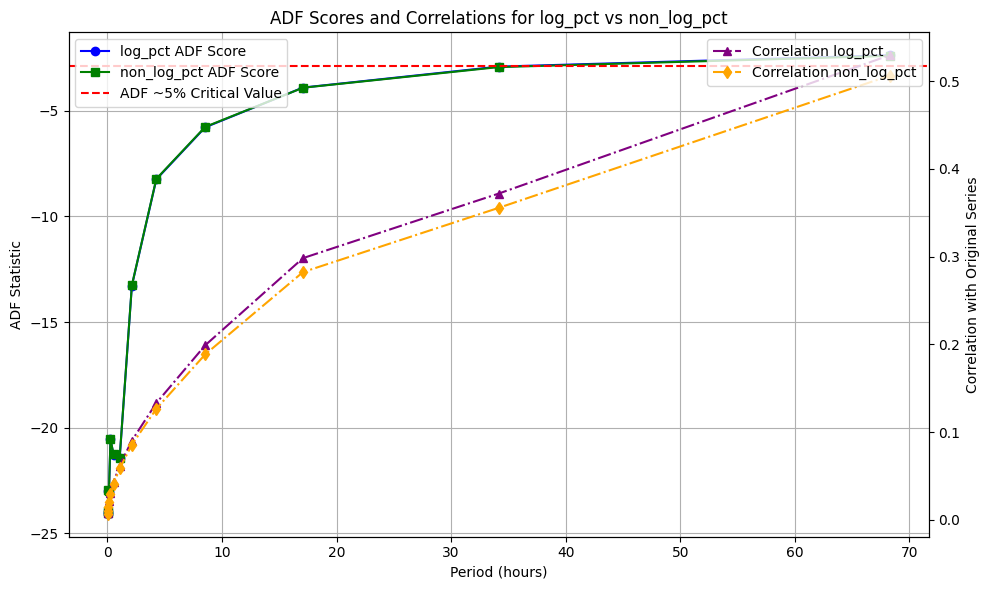

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from statsmodels.tsa.stattools import adfuller

# Sample time series (replace with your own data)
np.random.seed(0)
series = data["Close"][-(60*24*25*1):]  # pd.Series(np.cumsum(np.random.randn(500)) + 100

# Periods to analyze: [0, 1, 2, 4, 8, 16, 32, 64, ...]
lags = [2**i for i in range(13)]
if 1 not in lags:
    lags.insert(1, 1)

log_pct_adf_scores = []
non_log_pct_adf_scores = []
cor_log = []
cor_non_log = []

for lag in tqdm(lags):
    # log_pct: log(1 + (series - series.shift(lag)) / series.shift(lag))
    log_pct = np.log1p(series.pct_change(periods=lag).fillna(0))
    log_pct_adf_scores.append(adfuller(log_pct)[0])
    # Correlation between log_pct and original series
    cor_log.append(series.corr(pd.Series(log_pct, index=series.index)))

    # non_log_pct: (series - series.shift(lag)) / series.shift(lag)
    non_log_pct = series.pct_change(periods=lag).fillna(0)
    non_log_pct_adf_scores.append(adfuller(non_log_pct)[0])
    # Correlation between non_log_pct and original series
    cor_non_log.append(series.corr(pd.Series(non_log_pct, index=series.index)))

lags = np.array(lags) / 60  # Convert lags to hours

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot ADF scores on primary y-axis
ax1.plot(lags, log_pct_adf_scores, marker='o', label='log_pct ADF Score', color='blue')
ax1.plot(lags, non_log_pct_adf_scores, marker='s', label='non_log_pct ADF Score', color='green')
ax1.axhline(-2.86, color='red', linestyle='--', label='ADF ~5% Critical Value')
ax1.set_xlabel('Period (hours)')
ax1.set_ylabel('ADF Statistic', color='black')
ax1.grid(True)
ax1.legend(loc='upper left')

# Create secondary y-axis for correlations
ax2 = ax1.twinx()
ax2.plot(lags, cor_log, marker='^', label='Correlation log_pct', color='purple', linestyle='-.')
ax2.plot(lags, cor_non_log, marker='d', label='Correlation non_log_pct', color='orange', linestyle='-.')
ax2.set_ylabel('Correlation with Original Series', color='black')
ax2.legend(loc='upper right')

# Title and layout
plt.title('ADF Scores and Correlations for log_pct vs non_log_pct')
plt.tight_layout()
plt.show()

- when balancing stationarity and memory(long term trends), we see:
- period < 20hrs = good stationarity
  - log or not
  - necessary
- period > 10hrs = good memory(trend info)
  - log prefered
  - not necessary, only if you want trend info


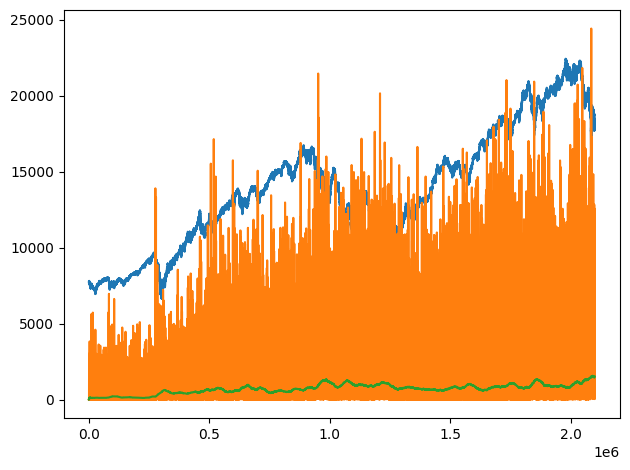

In [20]:
df = data.reset_index(drop=True)
plt.plot(df["Close"])
plt.plot(df["Volume"])
plt.plot(df["Volume"].rolling(60*24*25*1, min_periods=1).mean())  # 1 month
plt.tight_layout()
plt.show()

100%|██████████| 6/6 [01:00<00:00, 10.01s/it]


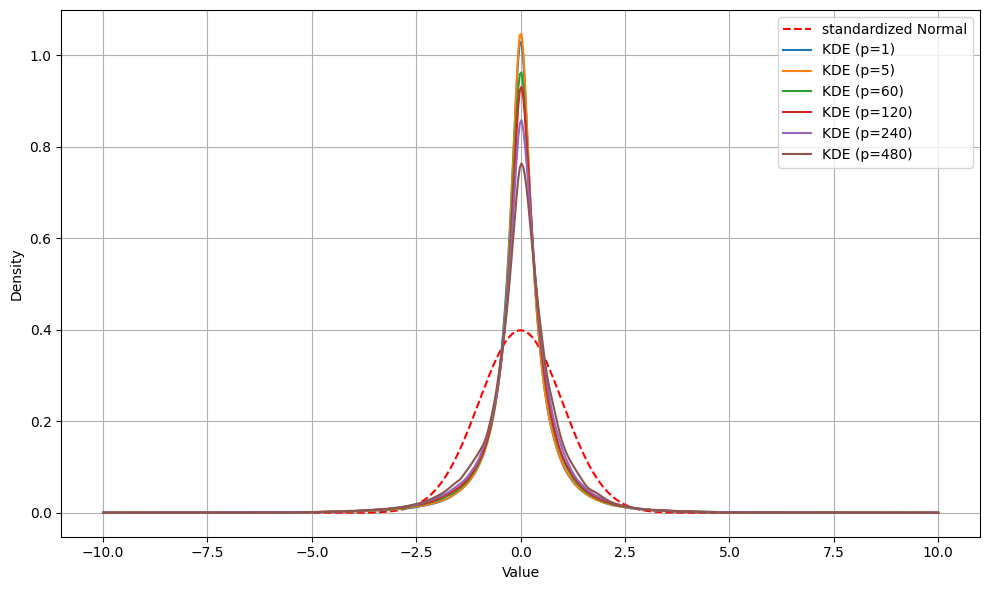

In [17]:

# plt.plot(data["Close"])
# plt.plot(data["Volume"])
MAX = 0.02
MIN = -0.02
BIN = 500
x = np.linspace(-10, 10, BIN)
plt.figure(figsize=(10, 6))
plt.plot(x, norm.pdf(x, 0, 1), 'r--', label=f'standardized Normal')


def add_hist(data: pd.DataFrame, period):
    returns = np.log1p(data["Close"].pct_change(periods=period).fillna(0))  # .clip(MIN, MAX)
    mu, std = norm.fit(returns)
    standardized_returns = (returns - mu) / std
    kde = gaussian_kde(standardized_returns, bw_method=0.05)
    plt.plot(x, kde(x), label=f'KDE (p={period})')


for period in tqdm([1, 5, 60*1, 60*2, 60*4, 60*8]):
    add_hist(data, period)
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
def find_threshold(imbalances, target_bars):
    def compute_bar_count(x):
        acc = 0
        bar_count = 0
        for imb in imbalances:
            acc += imb
            if abs(acc) >= x:
                bar_count += 1
                acc = 0
        return bar_count

    # Define search bounds
    abs_imbs = [abs(imb) for imb in imbalances]
    assert any(abs_imbs), "At least one imbalance must be non-zero"
    x_min = min(imb for imb in abs_imbs if imb > 0)  # Smallest non-zero absolute imbalance
    x_max = sum(abs_imbs)  # Total absolute imbalance

    # Binary search with early stopping and max iterations
    while True:
        x_mid = (x_min + x_max) * 0.5
        bars = compute_bar_count(x_mid)
        if (abs(bars - target_bars) <= 5) or (x_max - x_min < 1):
            return (x_min + x_max) * 0.5  # Return mean of last two x values
        if bars > target_bars:
            x_min = x_mid  # Too many bars, increase threshold
        else:
            x_max = x_mid  # Too few or equal bars, decrease threshold


def proc_volume_imbalance_bar(df):
    df['Date'] = df['Time'].apply(lambda x: int(str(x)[:8]))
    df['Label'] = np.sign(df['Close'].pct_change()).replace(0, np.nan).ffill().fillna(0).astype(int)
    df['Imb'] = df['Label'] * df['Volume']

    # Initialize variables
    expected_bars = 60*24/10  # Expected number of bars per day (10min bar)
    N = 7*4                   # Number of bars to use for EMA calculation
    alpha = 2 / (N + 1)       # EMA smoothing factor
    ema_thresh = None         # Start with no threshold
    bars = []
    daily_imbs = []           # Track daily imbalances
    daily_count = 0           # Count bars per day

    # Accumulators for bar formation
    cumm_imb, cumm_vol, cumm_dollar = 0, 0, 0
    price_buffer = []
    prev_date = df['Date'].iloc[0]

    for i, (time, date, close, imb, volume) in enumerate(zip(df['Time'], df['Date'], df['Close'], df['Imb'], df['Volume'])):
        # New day: update threshold based on previous day's data
        if date != prev_date:
            if len(daily_imbs) > 60*2 and daily_count > 0:
                # Estimate threshold: total imbalance / target bars
                daily_thresh = find_threshold(daily_imbs, expected_bars)
                ema_thresh = daily_thresh if ema_thresh is None else (alpha * daily_thresh + (1 - alpha) * ema_thresh)
            daily_imbs = []
            daily_count = 0
            prev_date = date

        # Calculate imbalance
        daily_imbs.append(imb)

        # Accumulate for bar formation
        cumm_imb += imb
        cumm_vol += volume
        cumm_dollar += close * volume
        price_buffer.append(close)

        # Use current EMA threshold (default to 0 for first day)
        thresh = ema_thresh if ema_thresh is not None else 0

        # Form a bar if threshold exceeded
        if abs(cumm_imb) >= thresh:
            open = price_buffer[0]
            high = np.max(price_buffer)
            low = np.min(price_buffer)
            close_price = price_buffer[-1]
            vwap = cumm_dollar / cumm_vol if cumm_vol > 0 else close_price
            bars.append((time, date, open, high, low, close_price, vwap, thresh))
            daily_count += 1

            # Reset accumulators
            cumm_imb, cumm_vol, cumm_dollar = 0, 0, 0
            price_buffer = []

    # Return bars as DataFrame
    return pd.DataFrame(bars, columns=['Time', 'Date', 'Open', 'High', 'Low', 'Close', 'Vwap', 'Thresh'])


def proc_run_bar(df, thresh):
    open, low, high, close, cumm_vol, vol_price, b, s = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    collector, bar, thresh_buffer = [], [], []

    for i, (label, price, date, volume) in enumerate(zip(df['Label'], df['Close'], df['Date'], df['Volume'])):
        if label == 1:
            b = b + label
        else:
            s = s + label
        theta = max(b, abs(s))

        cumm_vol = cumm_vol + volume
        vol_price = vol_price + (price * volume)
        collector.append(price)
        if theta >= thresh:
            open = collector[0]
            high = np.max(collector)
            low = np.min(collector)
            close = collector[-1]
            vwap = vol_price / cumm_vol
            bar.append((date, i, open, low, high, close, vwap))
            a = len(collector) * max(((b/len(collector)), (1-(b/len(collector)))))
            thresh_buffer.append(a)
            if i > 500000:
                thresh = np.average(thresh_buffer)
            theta, open, low, high, close, cumm_vol, vol_price, b, s = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
            collector = []
    cols = ['Date', 'Index', 'Open', 'Low', 'High', 'Close', 'Vwap']
    run_bar = pd.DataFrame(bar, columns=cols)
    return run_bar


if __name__ == '__main__':
    import numpy as np
    import pandas as pd
    import plotly.graph_objects as go
    from statsmodels.graphics.tsaplots import plot_acf
    from statsmodels.graphics.tsaplots import plot_pacf
    import seaborn as sns
    import scipy.stats as stats

    # Import Data
    df = data
    df = data[-(60*24*25*1):]
    df.index.name = 'Time'
    df = df.reset_index()

    print(df)

    df['Dollar'] = df['Close']*df['Volume']

    # Generate imbalance bars
    bar_vimb = proc_volume_imbalance_bar(df)
    print(bar_vimb)

    # # Generate run bars
    # run_bar = proc_run_bar(df, thresh_run)
    # print(run_bar)

    # Plot bars
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df['Time'], y=df['Close'], mode='lines', name='Time bar'))
    fig.add_trace(go.Candlestick(x=bar_vimb['Time'], open=bar_vimb['Open'], high=bar_vimb['High'], low=bar_vimb['Low'], close=bar_vimb['Close'], name='Volume imbalance bar'))
    fig.update_layout(
      title='Sampling methods',
      xaxis_title='Date',
      yaxis_title='Price',
      xaxis_rangeslider_visible=False,
      xaxis=dict(type='category')  # This thickens the candle visually
      )
    fig.show()

               Time     Close  Volume      High       Low
0      202503150457  19876.50    13.0  19876.50  19874.00
1      202503150458  19871.25    46.0  19876.00  19870.00
2      202503150459  19871.00    19.0  19877.00  19869.00
3      202503170600  19880.00   617.0  19899.25  19855.00
4      202503170601  19870.00   440.0  19884.75  19858.75
...             ...       ...     ...       ...       ...
35995  202504230755  18760.75   339.0  18763.50  18756.75
35996  202504230756  18761.25   220.0  18762.75  18758.50
35997  202504230757  18760.00   353.0  18765.25  18759.75
35998  202504230758  18761.00   223.0  18763.75  18758.00
35999  202504230759  18761.25   166.0  18762.50  18758.75

[36000 rows x 5 columns]
              Time      Date      Open      High       Low     Close   
0     202503150457  20250315  19876.50  19876.50  19876.50  19876.50  \
1     202503150458  20250315  19871.25  19871.25  19871.25  19871.25   
2     202503150459  20250315  19871.00  19871.00  19871.00  19